----
Apply word2vec to dataset
-----

- Apply word2vec to data:
    - Download some data
    - Train on it a bit
    - Visualize the result
- Describe the pre-processing steps needed for word2vec
- Explain how t-sne is the preferred algorithm for high dimensional visualization

This notebook is based on a [TensorFlow tutorial](https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py).

In [1]:
reset -fs

In [2]:
import collections
import math
import os
from pprint import pprint
import random
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from sklearn.manifold import TSNE

%matplotlib inline  

----
Step 1: Download the data.
----

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


☝️ While this code is running, preview the code ahead.

In [4]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Dataset size: {:,} words'.format(len(words)))

Dataset size: 17,005,207 words


In [5]:
# Let's have a peek at the head
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [6]:
# Let's have a peek at the tail
words[-5:]

['one', 'nine', 'six', 'five', 'b']

Notice: None of the words are capitalized and there is no punctuation.

Preprocessing is an art. It depends on your raw data and how you plan to use your final data. You might want to encode ngrams, instead of just splitting all items into unigrams.

-----
Step 2: Build the dictionary 
-----

In [7]:
vocabulary_size = 50000

def build_dataset(words):
    """ Replace rare words with UNK token which stands for "unknown".
    It is called a dustbin category, aka sweep the small count items into a single group.
    """
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

In [8]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Reduce memory by getting rid of the "heavy" list of strings

In [9]:
data[:5] # An index of each word (as it appears in order) to its rank. Therefore we don't have reference the string

[5237, 3084, 12, 6, 195]

In [10]:
# dictionary # word: rank

In [11]:
# reverse_dictionary # rank: word

In [12]:
print('Most common words:')
pprint(count[:5])

Most common words:
[['UNK', 418391],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764)]


In [13]:
print('Most least words:')
pprint(count[-5:])

Most least words:
[('caenorhabditis', 9),
 ('taiping', 9),
 ('arabized', 9),
 ('draconis', 9),
 ('tellers', 9)]


----
Step 3: Function to generate a training batch for the skip-gram model.
-----

In [14]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [15]:
batch, labels = generate_batch(batch_size=8, 
                               num_skips=2, 
                               skip_window=1)

----
Step 4: Build and train a skip-gram model.
-----

In [16]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [17]:
# TensorFlow setup
graph = tf.Graph()

with graph.as_default():

    # Input data
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()

----
Step 5: Begin training.
-----

In [18]:
num_steps = 1 #100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to '%s':" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  279.151794434
Nearest to 'has': westport, lothair, guant, caribbean, solaris, shines, throughput, maul,
Nearest to 'many': warr, hydras, dwells, remainders, conan, kowloon, laymen, theremin,
Nearest to 'first': potable, charges, meninges, asylum, average, flexibility, stwertka, inflated,
Nearest to 'the': conjunctive, hain, sucker, clique, israeli, crystallography, orion, osh,
Nearest to 'eight': meningitis, jasmine, criollo, pol, nder, primates, lewd, christological,
Nearest to 'who': presto, pikes, gross, env, continuation, special, bohemians, slams,
Nearest to 'also': beryl, enclosing, iconostasis, peyton, viollet, crisp, mandrakelinux, jb,
Nearest to 'd': currency, signs, honshu, rpgs, roleplay, marrakech, boasted, konerko,
Nearest to 'this': baptismal, pv, mawson, technicolor, keeshonden, related, panentheism, amboise,
Nearest to 'new': accounts, revealed, mcguire, candide, myocardial, thule, soar, junichiro,
Nearest to 'other': asses, dahl, 

-----
Step 6: Visualize the embeddings.
----

We'll use t-sne.

[t-sne](https://lvdmaaten.github.io/tsne/) is a cool way to visualize of high-dimensional datasets by reducing the number dimensions.

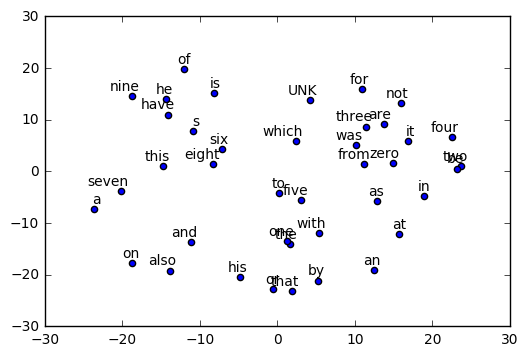

In [19]:
tsne = TSNE(perplexity=30, 
            n_components=2, 
            init='pca', 
            n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]

n_words_to_visualize = 40

for i, label in enumerate(labels[:n_words_to_visualize]):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

----
Reflective Questions
----

What do you see?

How would you describe the relationships?

------

Let's render and save more samples.

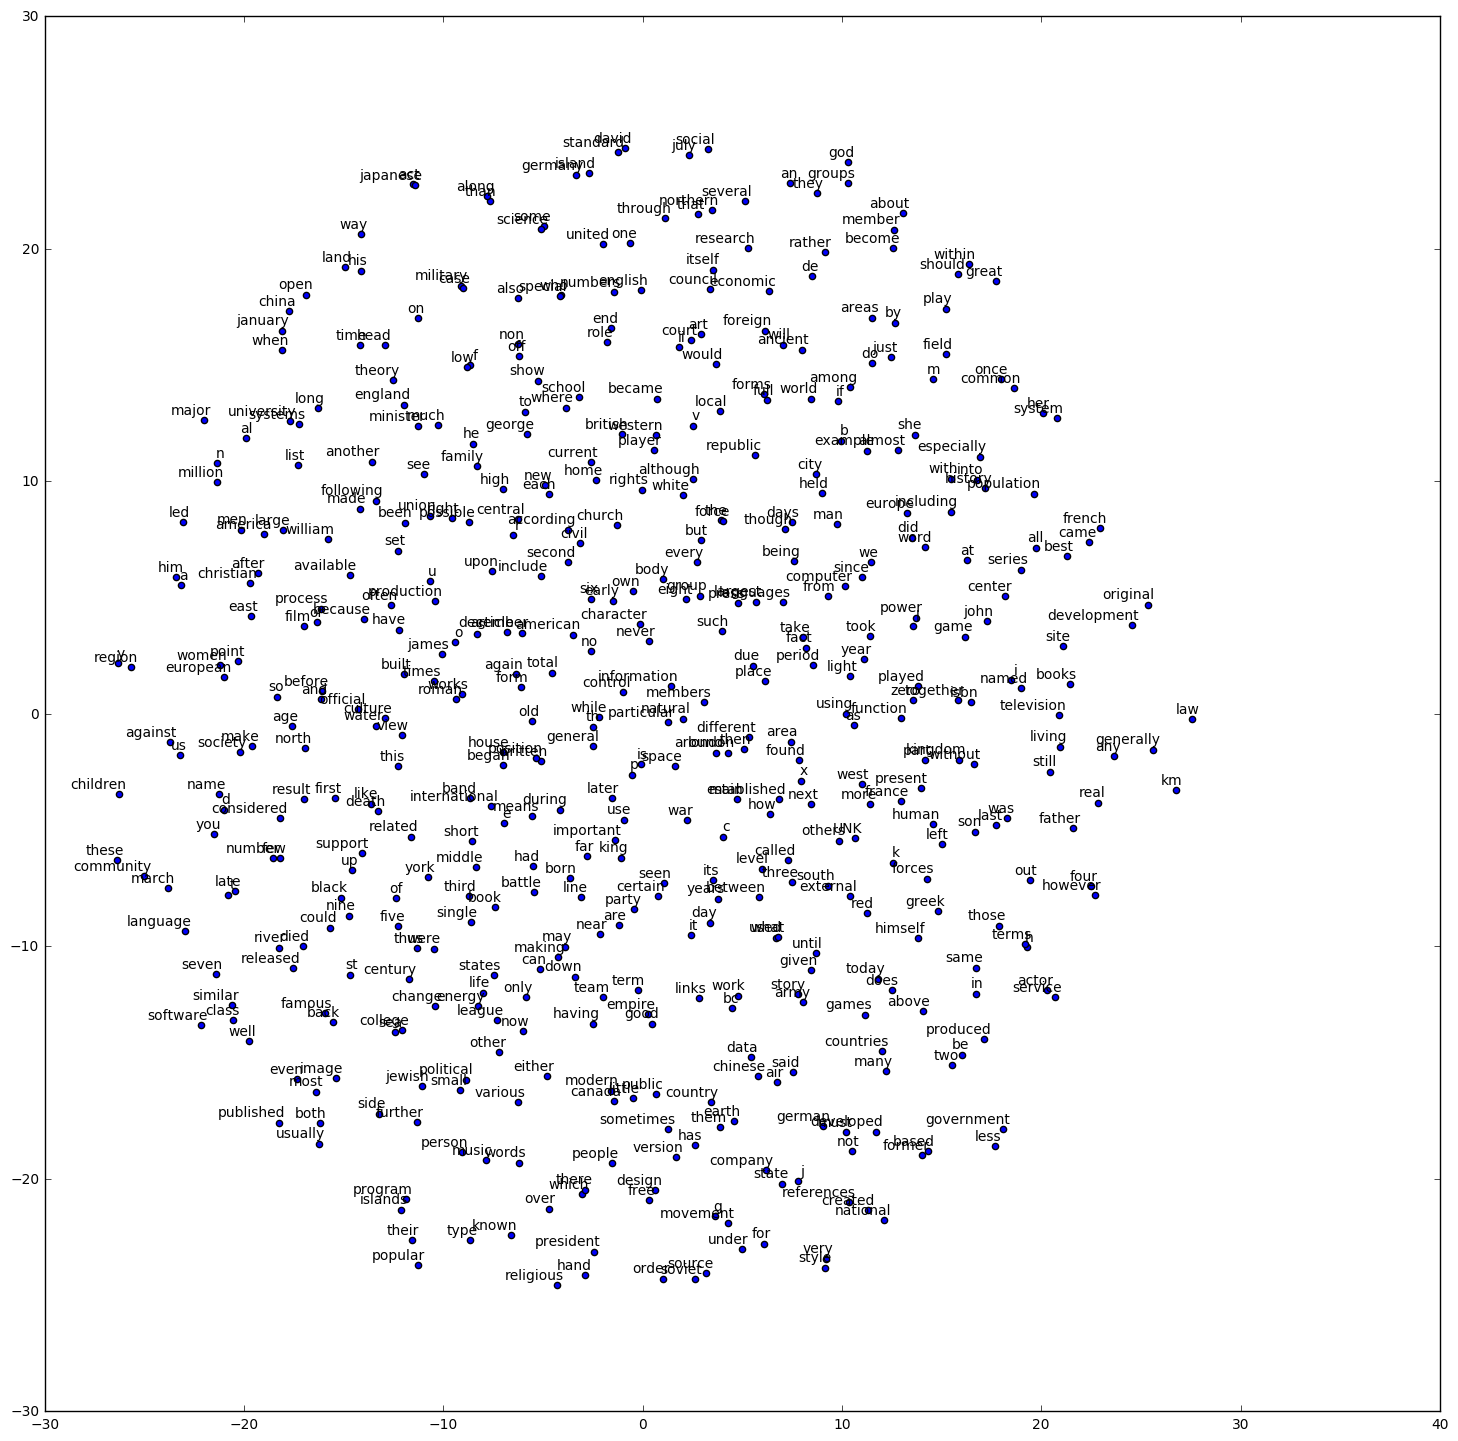

In [20]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)